# Main Objective

### 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note**: You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out `03. PyTorch Computer Vision` section 10 for ideas.

In [3]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine

### Get Data

In [11]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data\pizza_steak_sushi directory exists.


In [3]:

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Prepare data

In [12]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [13]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1ed3d1aa830>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [14]:
# Setup the model with pretrained weights and send it to the target device 
# model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
model_0 = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT).to(device)

#model_0 # uncomment to output (it's very long)

In [15]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [16]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train the model here

In [17]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [18]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0896 | train_acc: 0.4414 | test_loss: 0.9203 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8021 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7772 | train_acc: 0.7812 | test_loss: 0.7398 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7248 | train_acc: 0.7422 | test_loss: 0.6471 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6243 | test_acc: 0.8968
[INFO] Total training time: 25.105 seconds


### Make predictions on the entire test dataset with the model

In [13]:
from tqdm.auto import tqdm
# Make predictions
test_preds = []
model_0.eval()
with torch.inference_mode():
    for X,y in tqdm(test_dataloader):
        X,y = X.to(device), y.to(device)
        # Pass the data throught the model
        test_logits = model_0(X)

        # Convert the logits -> probabilities
        pred_probs = torch.softmax(test_logits, dim=1)

        # Convert the pred probs to labels
        pred_labels = torch.argmax(pred_probs, dim=1)

        # Add the pred labels to the test pred list
        test_preds.append(pred_labels)
test_preds = torch.cat(test_preds).cpu()

  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
test_preds

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

### Make a confusion matrix with the test preds and the truth labels

In [15]:
# tGet the true labels of the dataset
test_true = torch.cat([y for X,y in test_dataloader])

In [16]:
test_true

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [17]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


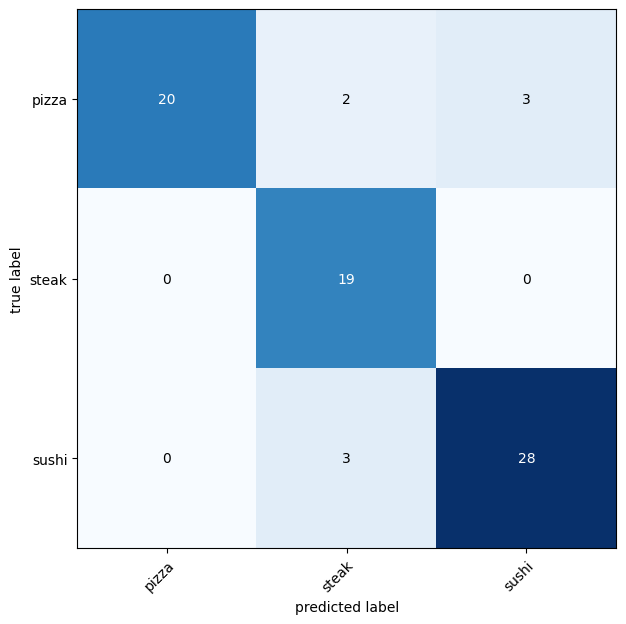

In [18]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=test_preds,
                         target=test_true)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)

### 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by wrong prediction and then descending predicted probabilities, this will give you the wrong predictions with the highest prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?
Want to:

* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong"

Want to :
* create a dataframe with sample, label, prediction, pred_prob
* Sort dataframe by correct (does label == prediction )
* sort dataframe by pred_prob (descending)
* Plot the top 5 images

In [34]:
 # Create a Dataframe with sample, lable, predicitons, pred_probs


# Get all test data parts
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list to dicitonaries with sample, laebls etc
def pred_and_store(test_paths, model, transform, class_names, device=device):
    test_pred_list = []
    for path in tqdm(test_paths):
        pred_dict = {}

        # Get sample path
        pred_dict['image_path'] = path

        # get the class names
        class_name = path.parent.stem
        pred_dict['class_name'] = class_name

        # Get Predictions and prediction probability
        from PIL import Image
        img = Image.open(path)
        transformed_image = transform(img).unsqueeze(0) # Transform the image and add batch to the dimension
        model.eval()
        with torch.inference_mode():
            pred_logit = model(transformed_image.to(device))
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label]

            # Make sure things in the dictionary are back to cpu
            pred_dict['pred_prob'] = pred_prob.unsqueeze(0).max().cpu().item()
            #pred_dict['pred_label'] = pred_label.cpu()
            pred_dict['pred_class'] = pred_class


        # Does the pred match the true labels?
        pred_dict['correct'] = class_name == pred_class

        # Add the dictionary to the list of pred
        test_pred_list.append(pred_dict)
    return test_pred_list


In [35]:
test_pred_dict = pred_and_store(test_paths=test_data_paths,
               model=model_0,
               transform=simple_transform,
               class_names=class_names)

  0%|          | 0/75 [00:00<?, ?it/s]

In [36]:
test_pred_dict

[{'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7351178526878357,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.605269193649292,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4656949043273926,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7869228720664978,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4020727872848511,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
  'class_n

In [41]:
# Turn the dictionary to DataFrame
import pandas as pd
test_pred_df = pd.DataFrame.from_dict(test_pred_dict)
# Sort dataframe by correct is False
top_five_most_wrong = test_pred_df.sort_values(by=['correct','pred_prob'], ascending=[True,False]).head(5)


C:\Users\PC\AppData\Local\Temp\ipykernel_9744\1095466968.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = row[0]
C:\Users\PC\AppData\Local\Temp\ipykernel_9744\1095466968.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = row[1]
C:\Users\PC\AppData\Local\Temp\ipykernel_9744\1095466968.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_class = row[3]
C:\Users\PC\AppData\Local\Temp\ipykernel_9744\109

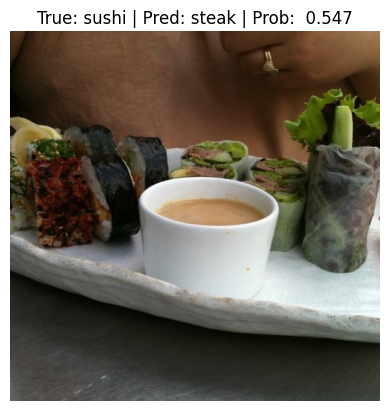

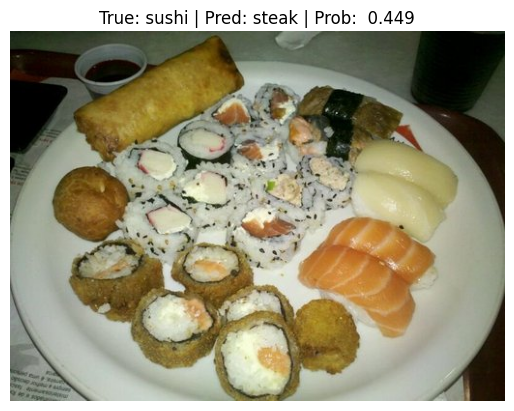

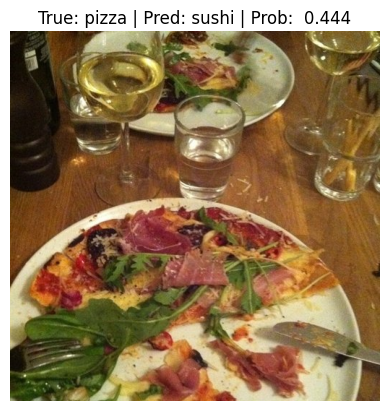

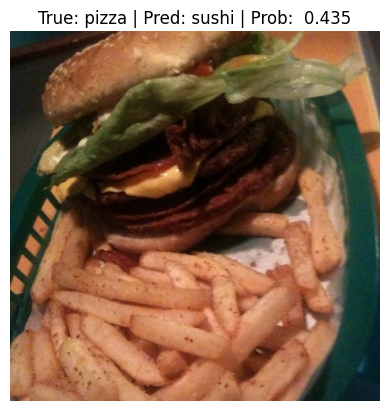

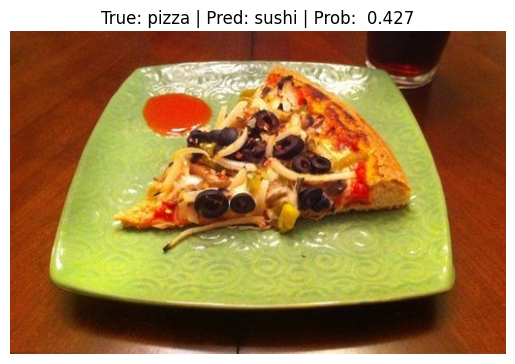

In [51]:
# Plot the top 5 wrong predictions
import torchvision
import matplotlib.pyplot as plt
# top_5_wrong_img_paths = top_five_most_wrong.image_path.to_list()
for row in top_five_most_wrong.iterrows():
    row = row[1]
    image_path = row[0]
    true_label = row[1]
    pred_class = row[3]
    pred_prob = row[2]
    # get the image as tensor
    img = torchvision.io.read_image(str(image_path))
    plt.figure()
    plt.imshow(img.permute(1,2,0))
    plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob: .3f}")
    plt.axis("off")
    #print(row[1][0])

### 3. Predict on your own image of pizza / steak / sushi - how does the model go? what happens if you predict on an image that isn't pizza/steak/sushi?

In [58]:
# get an image of pizza/steak/sushi
# get an image of not pizza/steak/sushi
with open(data_path / "pizza_new.png", "wb") as f:
    request = requests.get("https://unsplash.com/photos/LppAkC7s6u4/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8MTl8fHBpenphfGVufDB8fHx8MTcyMTY5NTEyM3ww&force=true")
    #print("Downloading pizza, steak, sushi data...")

    f.write(request.content)

In [60]:
# opening the image
from PIL import Image
pizza_img = Image.open(data_path/"pizza_new.png")

In [62]:
# To vectorize the image
img_vector = np.asarray(pizza_img)

In [66]:
# Make a function to pred and plot Image

def pred_and_plot(image_path, model, transform,
                  class_names, device=device):
    #open image
    image = Image.open(image_path)

    # transform the image
    transformed_image = transform(image)

    # pred on image
    model.eval()
    with torch.inference_mode():
        # unsqueeze adds batch dimension to the image
        pred_logits = model(transformed_image.unsqueeze(0).to(device))
        pred_label = torch.argmax(torch.softmax(pred_logits, dim=1), dim=1)

        # plot image and pred
        plt.figure()
        plt.imshow(image)
        plt.title(f"Pred: {class_names[pred_label]}")
        plt.axis(False)


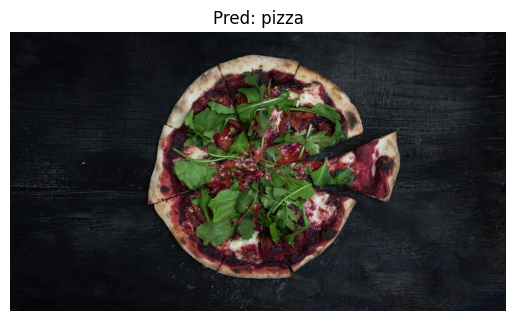

In [67]:
pred_and_plot(image_path=data_path/"pizza_new.png",
              model=model_0,
              transform=simple_transform,
              class_names=class_names,
              device=device)

In [68]:
# get an image of not pizza/steak/sushi
with open(data_path / "apple.png", "wb") as f:
    request = requests.get("https://unsplash.com/photos/JfodWBAIEF8/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8N3x8YXBwbGUlMjBmcnVpdHxlbnwwfHx8fDE3MjE3MzUxMjB8MA&force=true")
    #print("Downloading pizza, steak, sushi data...")

    f.write(request.content)


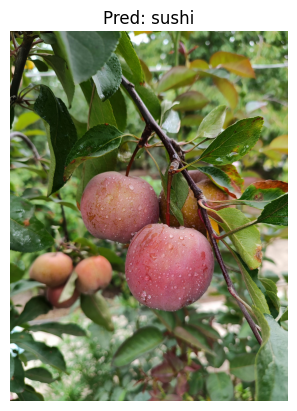

In [69]:
# prediction on the not apple imahe
pred_and_plot(image_path=data_path/"apple.png",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

### 4. Train the model from section above for longer ( 10 epochs), what happens to the performance?

In [19]:
# Setup the model with pretrained weights and send it to the target device 
# model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
from torchinfo import summary


model_1 = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT).to(device)
# Freeze the base layers (tweaking the model for our own features of 3 from 1000 -> 3 outputs)
for param in model_1.features.parameters():
    param.requires_grad = False

# Change the classification head
model_1.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1280, out_features=len(class_names),
              bias=True)
).to(device)

summary(model_1,
                  input_size=[32,3,224,224],
                  col_names=["input_size","output_size","trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]        [32, 16, 112, 112]        False
│    │    └─MBConv: 3-4                                 [32, 32, 112, 112]        [32

In [20]:
# create a new loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)



In [43]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0302 | train_acc: 1.0000 | test_loss: 0.3861 | test_acc: 0.8977
Epoch: 2 | train_loss: 0.0518 | train_acc: 1.0000 | test_loss: 0.3157 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.1239 | train_acc: 0.9844 | test_loss: 0.3107 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.0621 | train_acc: 1.0000 | test_loss: 0.2376 | test_acc: 0.9489
Epoch: 5 | train_loss: 0.1426 | train_acc: 0.9805 | test_loss: 0.2923 | test_acc: 0.8873
[INFO] Total training time: 24.911 seconds


In [23]:
from typing import Dict

def plot_loss_curves(results: Dict[str,list[float]]):
    """Plot training curves of a reuslt dictionary"""
    # get the loss values of the results dicitonary
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of the results duitionary
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure out how many epochs were there
    epochs = range(len(results["train_loss"]))

    # setup the plott
    plt.figure(figsize=(15,7))

    # plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # plot the accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

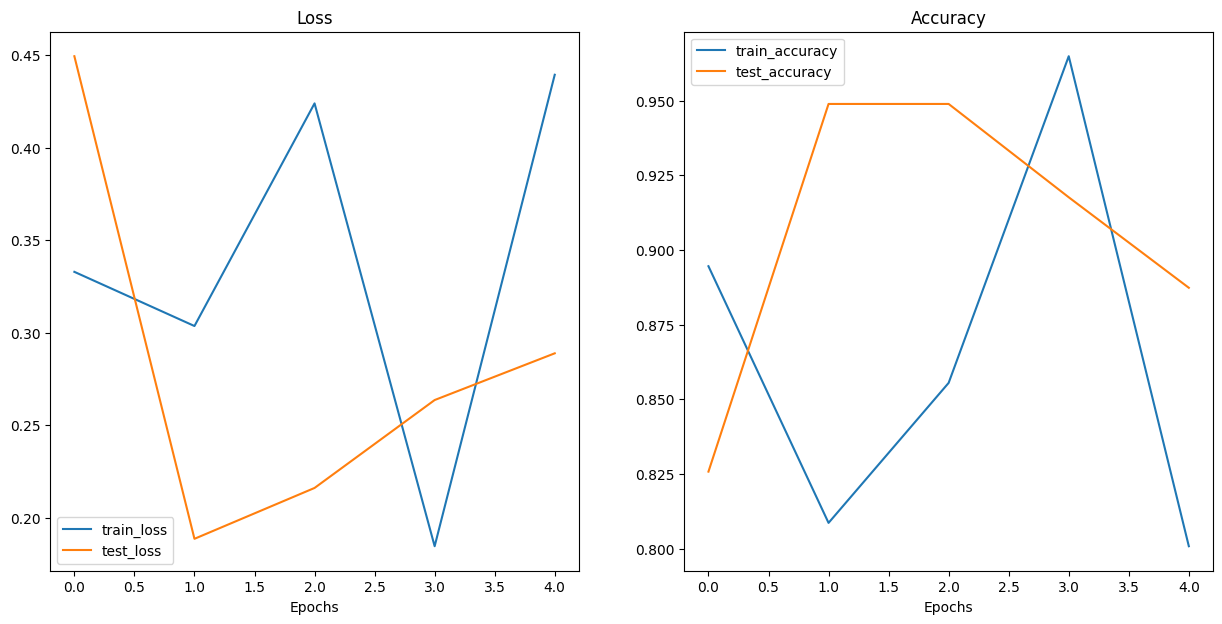

In [24]:
plot_loss_curves(results=model_1_results)

### 5. Train the model from section above with more data, 20% of the images from Food101 of Pizza, steak and sushi images

In [25]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = data_path / "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data 20% data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir20_percent = image_path / "test"

data\pizza_steak_sushi_20_percent directory exists.


In [26]:

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [27]:
# Create Dataloaders
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [28]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                               test_dir=test_dir20_percent,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1eda80b7df0>,
 ['pizza', 'steak', 'sushi'])

In [29]:
len(train_dataloader_20_percent), len(test_dataloader_20_percent)

(15, 5)

#### Get a pre-trained model


In [30]:
# Create a new model for 20 percent data
# Setup the model with pretrained weights and send it to the target device 
# model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
from torchinfo import summary


model_2 = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT).to(device)
# Freeze all the base layers (tweaking the model for our own features of 3 from 1000 -> 3 outputs)
for param in model_2.features.parameters():
    param.requires_grad = False

# Change the classification head
torch.manual_seed(42)
model_2.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1280, out_features=len(class_names),
              bias=True)
).to(device)

summary(model_2,
                  input_size=[32,3,224,224],
                  col_names=["input_size","output_size","trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]        [32, 16, 112, 112]        False
│    │    └─MBConv: 3-4                                 [32, 32, 112, 112]        [32

In [31]:
# Train the model with 20 percent of Data downloaded
# loss
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                             lr=0.001)


In [32]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9823 | train_acc: 0.5583 | test_loss: 0.6485 | test_acc: 0.9040
Epoch: 2 | train_loss: 0.7116 | train_acc: 0.7937 | test_loss: 0.5296 | test_acc: 0.9068
Epoch: 3 | train_loss: 0.5805 | train_acc: 0.8438 | test_loss: 0.4528 | test_acc: 0.8881
Epoch: 4 | train_loss: 0.4619 | train_acc: 0.8792 | test_loss: 0.4108 | test_acc: 0.9006
Epoch: 5 | train_loss: 0.4524 | train_acc: 0.8812 | test_loss: 0.3838 | test_acc: 0.9131
[INFO] Total training time: 29.600 seconds


In [33]:
# Check results wiht 5% of the data
max(model_0_results['test_acc']), min(model_0_results['test_loss'])

(0.8967803030303031, 0.6242739756902059)

In [34]:
# check results with 20 percent of the data
max(model_2_results['test_acc']), min(model_2_results['test_loss'])

(0.9130681818181818, 0.3837832033634186)

### 6. Try a different model from `torchvision.models` on the pizza, steak, sushi data and how does this model perform?
* We will have to change the size of the classification layer to suit our problem
* We may want to try an efficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`

In [35]:
# Create a transform to transform the data
from torchvision import transforms, models
efficient_b2_transform = transforms.Compose([
    transforms.Resize(size=(288,288)), # Effnet b2 size required
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225] )
])

In [36]:
# create a 10% dataset to compare this model wqwith model_0_resiults
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [38]:
# Import the data
from going_modular import data_setup
train_dataloader_effnet_b2, test_dataloader_effnet_b2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                      test_dir=test_dir,
                                                                                      transform=efficient_b2_transform,
                                                                                      batch_size=32,
                                                                                      num_workers=1)

In [40]:
# create a new effnet b2 model
model_3 = torchvision.models.efficientnet_b2(weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT).to(device)
#model_3

# Freeze all the base layers
for param in model_3.parameters():
    param.requires_grad = False

# Change the classifier head to change our requirements
model_3.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=len(class_names), bias=True)
  )

# Get the summary of the model
summary(model_3, input_size=[32,3,288,288],
        col_names=["input_size","output_size","trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [32, 3, 288, 288]         [32, 3]                   Partial
├─Sequential: 1-1                                       [32, 3, 288, 288]         [32, 1408, 9, 9]          False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 288, 288]         [32, 32, 144, 144]        False
│    │    └─Conv2d: 3-1                                 [32, 3, 288, 288]         [32, 32, 144, 144]        False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 144, 144]        [32, 32, 144, 144]        False
│    │    └─SiLU: 3-3                                   [32, 32, 144, 144]        [32, 32, 144, 144]        --
│    └─Sequential: 2-2                                  [32, 32, 144, 144]        [32, 16, 144, 144]        False
│    │    └─MBConv: 3-4                                 [32, 32, 144, 144]        [32

In [41]:
# Train the model with 20 percent of Data downloaded
# loss
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(),
                             lr=0.001)

In [42]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_3_results = engine.train(model=model_3,
                       train_dataloader=train_dataloader_effnet_b2,
                       test_dataloader=test_dataloader_effnet_b2,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1323 | train_acc: 0.3242 | test_loss: 0.9761 | test_acc: 0.4886
Epoch: 2 | train_loss: 0.8979 | train_acc: 0.7695 | test_loss: 0.8865 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.8023 | train_acc: 0.8047 | test_loss: 0.8157 | test_acc: 0.7841
Epoch: 4 | train_loss: 0.7365 | train_acc: 0.7227 | test_loss: 0.7016 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6797 | train_acc: 0.8008 | test_loss: 0.6729 | test_acc: 0.8769
[INFO] Total training time: 26.229 seconds


Which one did the best?
Experiments:
* model_0 = 10% data, effnet b0, 5 epochs
* model_1 = 10% data, effnet b0, 10 epochs ( double the epochs)
* model_2 = 20% data, effnet b0, 5 epochs ( Double the data)
* model_3 = 10% data, effnet b2, 5 epochs ( doeble the model parameters)

In [44]:
max(model_0_results['test_acc']), min(model_0_results['test_loss'])

(0.8967803030303031, 0.6242739756902059)

In [45]:
max(model_1_results['test_acc']), min(model_1_results['test_loss'])

(0.9488636363636364, 0.23763888825972876)

In [46]:
max(model_2_results['test_acc']), min(model_2_results['test_loss'])

(0.9130681818181818, 0.3837832033634186)

In [47]:
max(model_3_results['test_acc']), min(model_3_results['test_loss'])

(0.8768939393939394, 0.6729159752527872)